In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import recipinvgauss, invgamma
import scipy.sparse as sps
from scipy.sparse.linalg import cg
from fastprogress import progress_bar

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

from runningstatistics import StatsTracker
import jlinops

# Make toy problem

In [35]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.05
noise_var = noise_stdev**2
blur_sigma = 6.0
blur_op = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma, mode="constant")
noisy_signal = blur_op.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

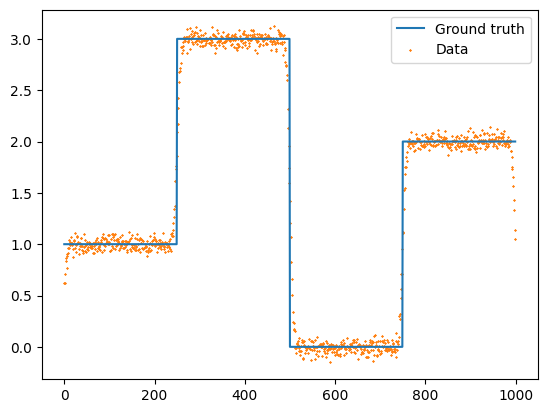

In [36]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [37]:
# Define forward operator and regularization matrix
F = blur_op
R, _ = jlinops.first_order_derivative_1d(n, boundary="none")
R = jlinops.MatrixLinearOperator(R)

# Sampler

In [131]:
class InvGammaGibbsSampler:
    """Implements the Bayesian LASSO hierarchical sampler for the L1 problem.
    """

    def __init__(self, F, R, y, noise_var=1.0, hparams=None):

        self.F = F
        self.R = R
        self.y = y
        self.noise_var = noise_var
        self.noise_stdev = np.sqrt(noise_var)
        self.hparams = hparams
        
        self.m = F.shape[0]
        self.k = R.shape[0]
        self.n = R.shape[1]

        self.last_x_solve = None


    def sample(self, n_samples, x0=None, n_burn=0, warmstarting=True, vartheta0=None, vartheta_update_freq=25, x_params={}):
        """Runs the Gibbs sampler.
        """

        # Initialize
        if x0 is None:
            x = np.zeros(self.F.shape[1])
        else:
            x = x0

        if vartheta0 is None:
            vartheta = 1.0
        else:
            vartheta = vartheta0

        if warmstarting:
            self.last_x_solve = x.copy()

        # Create trackers
        x_tracker = StatsTracker(self.F.shape[1])
        theta_tracker = StatsTracker(self.R.shape[0])

        # For taking care of vartheta updates
        # r = -1
        vartheta_update_fn = lambda theta_ss_est: np.power( (1.0/(self.k*self.hparams["s"]))*theta_ss_est, -1) 
        theta_sum_tracker = StatsTracker((1,))
        vartheta_hist = [vartheta]
        theta_sums_all = []

        # For tracking when gaussian draws are accepted
        x_draws_accepted = 0

        # Run the sampler
        for j in progress_bar(range(n_samples+n_burn)):

            # Update theta
            theta = self.sample_theta(x, vartheta)

            # Update x
            x, accepted = self.sample_x(theta, x, **x_params)
            if j >= n_burn:
                if accepted:
                    x_draws_accepted += 1

            # For taking care of vartheta updates
            theta_sums_all.append( np.power(theta, -1).sum() )
            theta_sum_tracker.push( np.power(theta, -1).sum()  )

            if (j < n_burn) and (j%vartheta_update_freq == 0):

                # Get new lambda
                vartheta = vartheta_update_fn(theta_sum_tracker.mean()[0])
                vartheta_hist.append(vartheta)

                # Reset theta sum tracker
                theta_sum_tracker = StatsTracker((1,))
                
            # Push to tracker
            if j >= n_burn:
                x_tracker.push(x)
                theta_tracker.push(theta)


        results = {
            "x_tracker": x_tracker,
            "theta_tracker": theta_tracker,
            "vartheta_hist": np.asarray(vartheta_hist),
            "theta_sums_all": np.asarray(theta_sums_all),
            "x_draws_acceptance_rate": x_draws_accepted/n_samples,
            "last_x": x,
            "last_theta": theta,
        }

        return results


    def sample_x(self, theta, x_old, cg_maxits=None, cg_tol=1e-3, ar_step=True):
        """Given local variances theta, draws a sample for x.
        """


        # Update using RJPO method
        if cg_maxits is None:
            cg_maxits = self.n
        
        # Sample eta
        Ls = [ (1.0/self.noise_stdev)*self.F.T, self.R.T @ jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta))) ]
        Qmu = (1.0/self.noise_var)*(self.F.T @ self.y)
        eta = self.sample_eta(Qmu, Ls)

        # Solve system approximately
        Q = (1.0/self.noise_var)*(self.F.T @ self.F) + (self.R.T @ ( jlinops.MatrixLinearOperator(sps.diags(1.0/theta)) @ self.R ) )
        if self.last_x_solve is None:
            warmstart = None
        else:
            warmstart = - self.last_x_solve
        x_approx, _ = cg(Q, eta, x0=warmstart, maxiter=cg_maxits, tol=cg_tol)
        
        if not ar_step:
            return x_approx, True

        residual = eta - (Q @ x_approx)

        # Accept or reject
        log_uniform = np.log(np.random.uniform())
        log_accept = np.amin([0.0, -residual.T @ (x_old - x_approx)])

        if log_uniform < log_accept:
            x = x_approx
            accepted = True
        else:
            x = x_old
            accepted = False

        self.last_x_solve = x

        return x, accepted

    def sample_theta(self, x, vartheta):
        """Given x, draws a sample for the thetas.
        """

        # Get Rx
        Rx = self.R @ x

        # Get new params
        c = self.hparams["s"] + 0.5
        d = vartheta + 0.5*(Rx**2).sum()
        
        # Draw samples
        # sample = np.random.gamma(c, scale=d, size=self.R.shape[0])
        # sample = 1.0/sample
        sample = invgamma.rvs(a=c, scale=1.0/d, size=self.R.shape[0])
        assert np.all(sample > 0), "some thetas are no positive!"

        return sample


    def sample_eta(self, Qmu, Ls):
        """Draws a sample from $\mathcal{N}(Q \mu, Q)$. Here $Q$ is assumed to be of the form $Q = \sum_{i=1}^p L_i^T L_i$,
        where the $L_i$ are collected in Ls."""
         
        # Draw sample with correct covariance
        sample = np.zeros(self.n)
        for L in Ls:
            sample += L.matvec( np.random.normal(size=L.shape[1]) )

        # Add mean
        sample += Qmu
        
        return sample

In [132]:
hparams = {
    "s": 1.0,
    # "vartheta": 2*1e3,
}

sampler = InvGammaGibbsSampler(F, R, noisy_signal, noise_var=noise_var, hparams=hparams)

In [133]:
sampling_result = sampler.sample(n_samples=1000, x0=ground_truth, vartheta_update_freq=20, vartheta0=1e4, n_burn=1000, x_params={"cg_tol":1e-3, "ar_step":True})

In [134]:
sampling_result.keys()

dict_keys(['x_tracker', 'theta_tracker', 'vartheta_hist', 'theta_sums_all', 'x_draws_acceptance_rate', 'last_x', 'last_theta'])

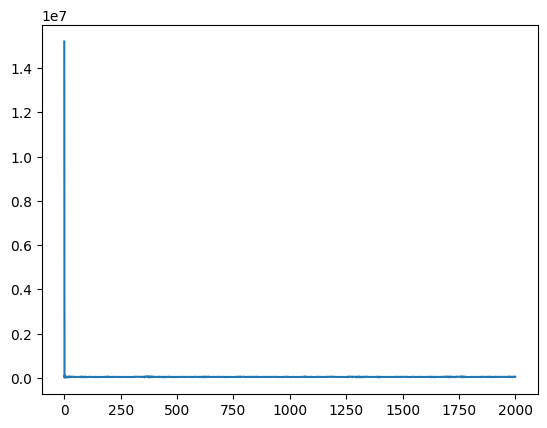

In [135]:
plt.plot(sampling_result["theta_sums_all"])

In [136]:
1/sampling_result["theta_sums_all"][-1]

2.2186038599453702e-05

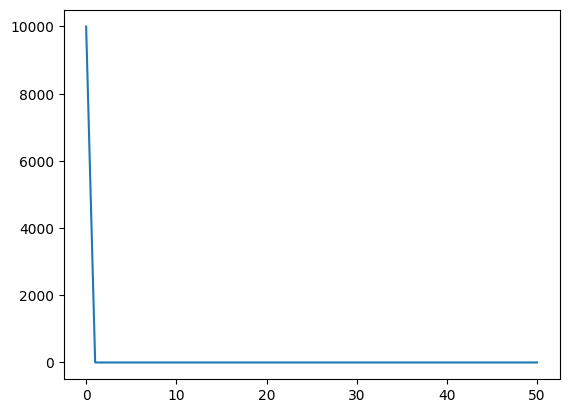

In [137]:
plt.plot(sampling_result["vartheta_hist"])
plt.show()

In [138]:
sampling_result["vartheta_hist"]

array([1.00000000e+04, 6.56935560e-05, 2.54414378e-02, 2.40432232e-02,
       2.72779653e-02, 2.58599223e-02, 2.86426994e-02, 2.62302023e-02,
       2.81814448e-02, 2.87617017e-02, 2.74276159e-02, 2.49163744e-02,
       2.65729010e-02, 2.62927749e-02, 2.87381853e-02, 2.73627786e-02,
       2.73613377e-02, 2.47760286e-02, 2.33030956e-02, 2.74265829e-02,
       2.06061604e-02, 2.40958387e-02, 2.59506840e-02, 2.73335381e-02,
       2.83852822e-02, 2.60752710e-02, 2.93487533e-02, 2.58508903e-02,
       2.65432166e-02, 2.62480265e-02, 2.57647371e-02, 2.60568968e-02,
       2.72278596e-02, 2.48101046e-02, 2.75400394e-02, 2.80457347e-02,
       2.63502160e-02, 2.88892594e-02, 2.78144540e-02, 2.69537497e-02,
       2.49812148e-02, 2.33378464e-02, 2.77249337e-02, 2.57717883e-02,
       2.61916996e-02, 2.68974412e-02, 2.69093597e-02, 2.65124969e-02,
       2.61541344e-02, 2.66526426e-02, 2.57354268e-02])

In [139]:
sampling_result["x_draws_acceptance_rate"]

0.26

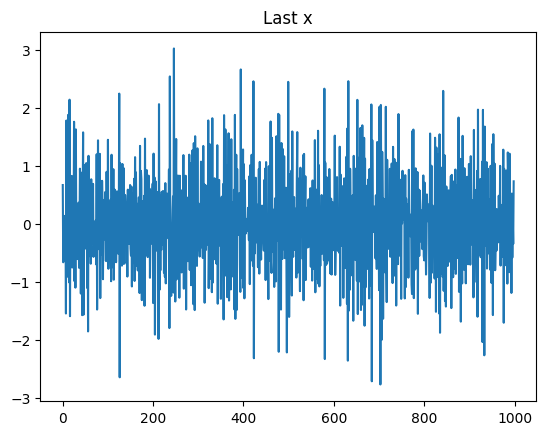

In [130]:
plt.plot(np.diff(sampling_result["last_x"]))
plt.title("Last x")
plt.show()

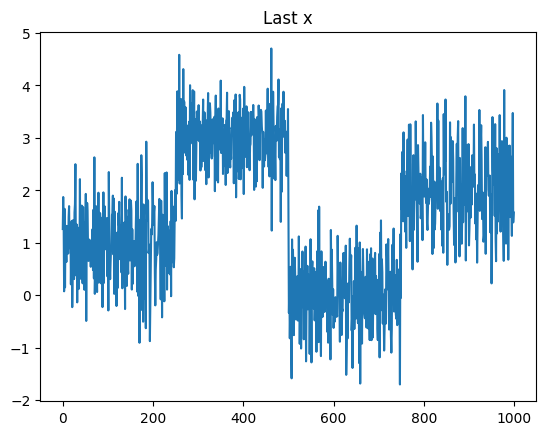

In [120]:
plt.plot(sampling_result["last_x"])
plt.title("Last x")
plt.show()

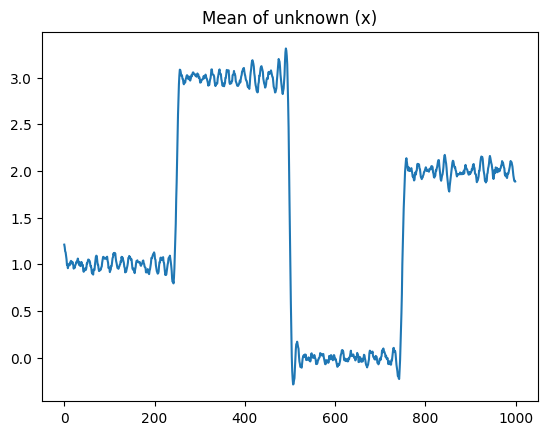

In [79]:
plt.plot(sampling_result["x_tracker"].mean())
plt.title("Mean of unknown (x)")
plt.show()

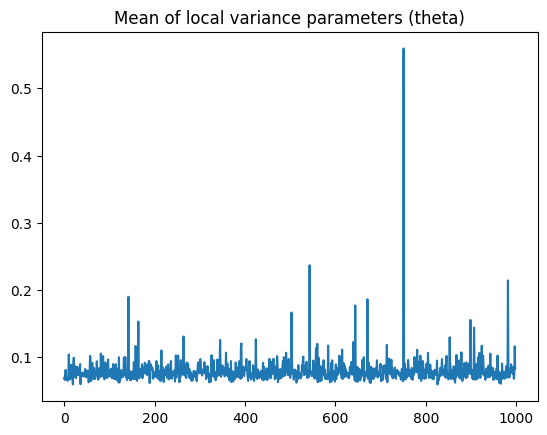

In [80]:
plt.plot(sampling_result["theta_tracker"].mean())
plt.title("Mean of local variance parameters (theta)")
plt.show()

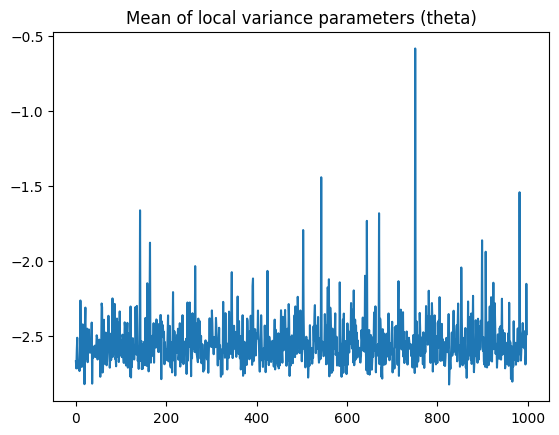

In [81]:
plt.plot(np.log(sampling_result["theta_tracker"].mean()))
plt.title("Mean of local variance parameters (theta)")
plt.show()

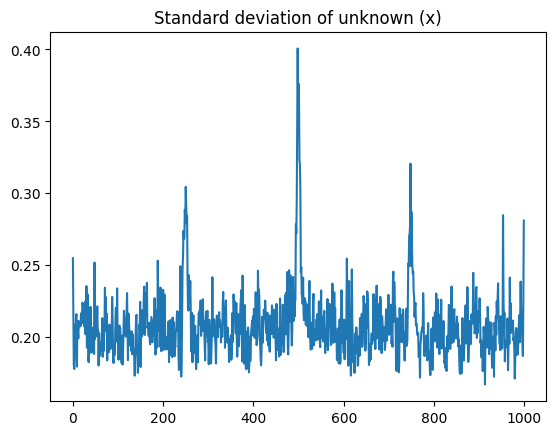

In [82]:
plt.plot(sampling_result["x_tracker"].stdev())
plt.title("Standard deviation of unknown (x)")
plt.show()

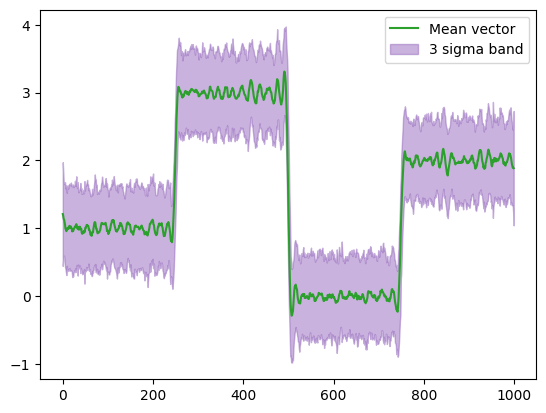

In [83]:
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()
plt.plot(grid, mu, label="Mean vector", color="C2")
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()